# Creating a GHZ state with IQM Deneb and Cirq

Creating a GHZ state is  a great task to understand the fine-grained differences between the architecture provided by IQM Deneb and other architectures like a standard square lattice or a heavy-hexagonal lattice. 

In this notebook, you will learn how to ...
* ... use the MOVE operation involving the computational resonator element.
* ... create a GHZ state with IQM Deneb.
* ... verify genuine multi-qubit entanglement by measuring the fidelity of the GHZ state using the multiple quantum coherence method.

By the end of this notebook, you will not only have a solid understanding of how to execute a circuit on IQM Deneb, but you will also appreciate the subtleties that differentiate various quantum computing architectures and their impact on quantum information processing. This exploration will provide you with the skills that are essential for advancing with this new quantum computing architecture and making full use of the computational resonator to advance the field of quantum computing.

### Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed:

In [16]:
%%capture
!pip install "iqm-client[cirq]"
!pip install matplotlib
!pip install pylatexenc

In order to access IQM Deneb through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [1]:
import os
os.environ["IQM_TOKEN"] = input()

## Connecting to IQM Deneb

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance.

In [10]:
from iqm.cirq_iqm.iqm_sampler import IQMSampler

server_url="https://cocos.resonance.meetiqm.com/deneb"
sampler = IQMSampler(server_url) 

# Instead of setting the environment variable, you could add the token as an argument to the IQMProvider constructor
# sampler = IQMSampler(server_url, token=token)

## Creating the GHZ state using a simulator

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. For the six qubits we have available on IQM Deneb, this can be represented as:

$$\frac{1}{\sqrt{2}}(∣000000⟩+ ∣111111⟩)$$

If we want to create a GHZ state for a simulator without considering connectivity constraints given by actual quantum computing hardware, we can just:

In [16]:
import cirq

# Create 6 qubits
num_qb = 6
qubits = [cirq.GridQubit(0, i) for i in range(num_qb)]

# Create a circuit
circuit = cirq.Circuit()

# Apply Hadamard gate to the first qubit
circuit.append(cirq.H(qubits[0]))

# Apply CNOT gates
for qb in qubits[1:]:
    circuit.append(cirq.CNOT(qubits[0], qb))

# Measure all qubits
circuit.append(cirq.measure(*qubits, key='result'))

# Draw the circuit
print(circuit)

(0, 0): ───H───@───@───@───@───@───M('result')───
               │   │   │   │   │   │
(0, 1): ───────X───┼───┼───┼───┼───M─────────────
                   │   │   │   │   │
(0, 2): ───────────X───┼───┼───┼───M─────────────
                       │   │   │   │
(0, 3): ───────────────X───┼───┼───M─────────────
                           │   │   │
(0, 4): ───────────────────X───┼───M─────────────
                               │   │
(0, 5): ───────────────────────X───M─────────────


## Creating the GHZ state with IQM Deneb

When adapting GHZ state generation to the star lattice topology, with a computational resonator as the central element, as seen in IQM Deneb, we need to approach things slightly differently.

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit. For this example, we select <code>q[0]</code> (the first qubit in the qubit register).
</li>
<li> After establishing the superposition, we <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600 border-radius: 0.2rem;">MOVE</span> <b>the state into the resonator</b>, which is given by the `comp_r` register. This step is crucial for preparing the system for further operations.
</li>
<li>  Next, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from the resonator to all other qubits</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits in register</b> <code>q</code> and map these measurements to the classical bit register called <code>c</code>. Note that the resonator is not measured in this process. 
</li>
</ol>

<div style="background-color: white;  margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);"> 
The <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation syntax requires the first index to be the qubit and the second index to be the resonator!
</div>

In [23]:
import cirq
from iqm.cirq_iqm.iqm_gates import IQMMoveGate

qubits = sampler.device.qubits
resonators = sampler.device.resonators

# Create a circuit
circuit = cirq.Circuit()

# Apply Hadamard gate to the first qubit
circuit.append(cirq.H(qubits[0]))

# MOVE into the resonator
circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))

# Apply CNOT gates
for qb in qubits[1:]:
    circuit.append(cirq.CNOT(resonators[0], qb))

# MOVE out of the resonator
circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))

# Measure all qubits
circuit.append(cirq.measure(*qubits, key='result'))

# Draw the circuit
print(circuit)

COMP_R (d=2): ───────MOVE(Res)───@───@───@───@───@───MOVE(Res)─────────────────
                     │           │   │   │   │   │   │
QB1 (d=2): ──────H───MOVE(QB)────┼───┼───┼───┼───┼───MOVE(QB)────M('result')───
                                 │   │   │   │   │               │
QB2 (d=2): ──────────────────────X───┼───┼───┼───┼───────────────M─────────────
                                     │   │   │   │               │
QB3 (d=2): ──────────────────────────X───┼───┼───┼───────────────M─────────────
                                         │   │   │               │
QB4 (d=2): ──────────────────────────────X───┼───┼───────────────M─────────────
                                             │   │               │
QB5 (d=2): ──────────────────────────────────X───┼───────────────M─────────────
                                                 │               │
QB6 (d=2): ──────────────────────────────────────X───────────────M─────────────


<div style="background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
With the circuit prepared, we can now send it to our quantum computer and examine the results. Therefore, we transpile the circuit which will carry out several transpilation steps, including decomposing the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gate into native gates. Then, we call the run method on backend to execute the circuit on the quantum computer.
</div>

In [31]:
decomposed_circuit = sampler.device.decompose_circuit(circuit)
print(decomposed_circuit)

result = sampler.run(decomposed_circuit, repetitions=1000)


                                              ┌──────┐   ┌──────┐   ┌──────┐   ┌──────┐
COMP_R (d=2): ────────────────MOVE(Res)───@─────────@──────────@──────────@──────────@────MOVE(Res)─────────────────
                              │           │         │          │          │          │    │
QB1 (d=2): ──────Y^0.5────X───MOVE(QB)────┼─────────┼──────────┼──────────┼──────────┼────MOVE(QB)────M('result')───
                                          │         │          │          │          │                │
QB2 (d=2): ──────Y^-0.5───────────────────@────Y^0.5┼──────────┼──────────┼──────────┼────────────────M─────────────
                                                    │          │          │          │                │
QB3 (d=2): ──────Y^-0.5─────────────────────────────@─────Y^0.5┼──────────┼──────────┼────────────────M─────────────
                                                               │          │          │                │
QB4 (d=2): ──────Y^-0.5─────────────────

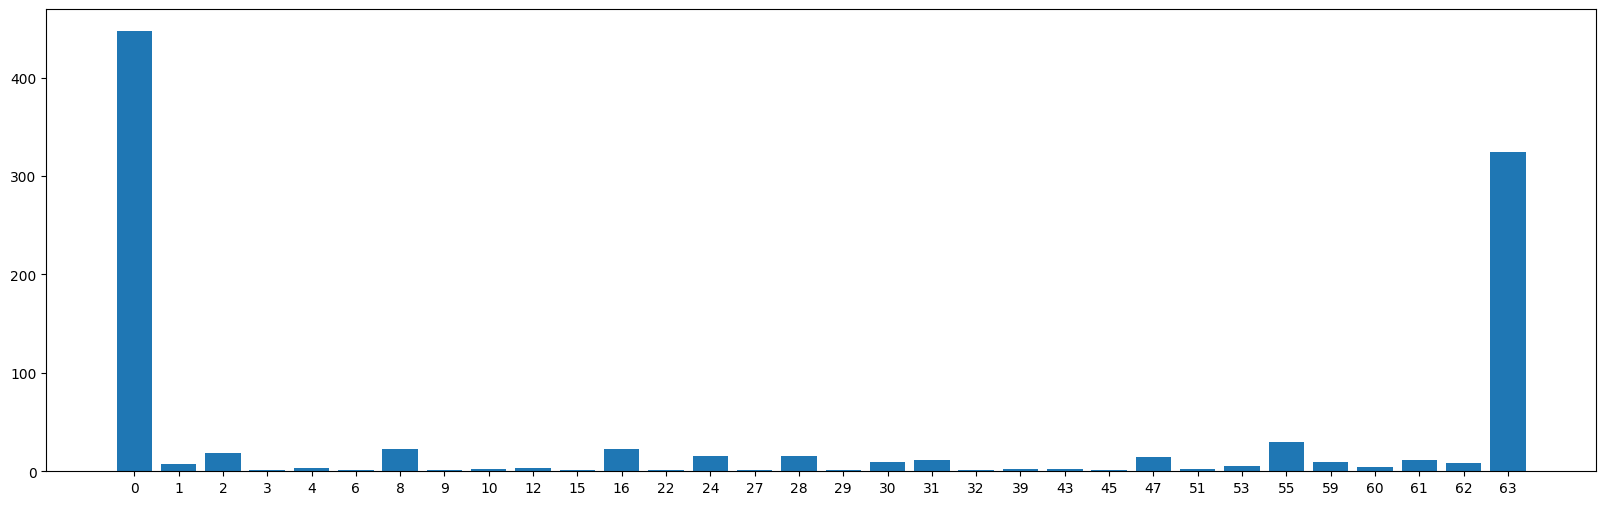

In [32]:
import matplotlib.pyplot as plt

counts = result.histogram(key='result')

# Sort keys numerically for proper plotting
sorted_counts = dict(sorted(counts.items()))

# Convert bitstrings to integers for plotting
x_labels = list(sorted_counts.keys())
x_values = range(len(x_labels))
y_values = list(sorted_counts.values())

# Plot histogram
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(x_values, y_values, tick_label=x_labels)

# Display plot
plt.show()

The result looks indeed like a GHZ state: We observe two distinct peaks corresponding to the bitstrings composed entirely of zeros and entirely of ones. The remaining counts are indicative of noise and errors within the system. You can experiment further and apply error mitigation schemes to reduce these errors.

## Verifying genuine multi-qubit entanglement by measuring the GHZ state fidelity

The GHZ state fidelity acts as a witness for genuine multi-qubit entanglement if found to be above $0.5$ (more precisely, it has been shown that this is equivalent to measuring a negative expectation value of a multipartite entanglement witness - see [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta) and references therein). This means that the measurement results cannot be explained without entanglement involving all qubits, so it is a great way to evaluate the "quantumness" of the computer. 

The fidelity of a mixed state is computed using the [formula](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) 
$$F(\text{ideal}, \text{measured})= \left(\text{Tr}\sqrt{\sqrt{\rho_{\text{ideal}}}\rho_{\text{measured}}\sqrt{\rho_{\text{ideal}}}}\right)^2$$

where $\rho_{\text{ideal}}$ is the density matrix of an ideal GHZ state (i.e. without noise) and $\rho_{\text{measured}}$ is the density matrix as given by the actual results of the quantum computer. The ideal GHZ state density matrix only has non-zero entries in the four corners of the density matrix $|00...0\rangle\langle00...0|$, $|00...0\rangle \langle11...1|$, $|11...1\rangle \langle00...0|$, $|11...1\rangle \langle11...1|$. This simplifies the process since we only need to measure these four components. In the fidelity formula, all other entries are effectively nullified by the zero entries in the ideal state matrix. 

From the experiment above we obtained the diagonal elements of $\rho_{\text{measured}}$, but we still need to measure the coherences along the anti-diagonal. We will use the method of multiple quantum coherences to measure these off-diagonal entries [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta). 

This method leverages the fact that for a GHZ state, a phase rotation $e^{i\phi}$ applied to all $n$ qubits results in the $|11...1\rangle$ component acquiring a cumulative phase of $e^{in\phi}$. The $|00...0\rangle$ component remains unaffected by this phase rotation and does not accumulate any phase. To measure this, we generate a GHZ state, apply phase shifts to all qubits, and then attempt to reverse the state using the circuit that initially created the GHZ state. From this, we can then observe the oscillation of the probability of the $|00...0\rangle$ component as we scan the phase angle from $0$ to $2\pi$. By fourier transforming the signal we can extract the amplitude of the oscillation happening at frequency $n$, which is a measure of the $|00...0\rangle \langle11...1|,|11...1 \rangle \langle00...0|$ coherences.

In order to perform these measurements, we first need to generate the phase-shifter circuits used in the method of multiple quantum coherences. We will create $2n+2$ of these circuits, which is the maximal step-size for detecting a signal oscillating at frequency $n$ according to the [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). 

In [37]:
import numpy as np
import cirq
from iqm.cirq_iqm.iqm_gates import IQMMoveGate

qubits = sampler.device.qubits
num_qb = len(qubits)
resonators = sampler.device.resonators

phases = np.linspace(0, 2 * np.pi, 2 * num_qb + 2)
circuits = []

for phase in phases:
    circuit = cirq.Circuit()

    # Creating a GHZ state
    circuit.append(cirq.H(qubits[0]))
    circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))  # MOVE into the resonator
    for qb in qubits[1:]:
        circuit.append(cirq.CNOT(resonators[0], qb))
    circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))  # MOVE out of the resonator

    # Adding phases
    for qb in qubits:
        circuit.append(cirq.Z(qb) ** (phase / np.pi))

    # Undoing GHZ can be achieved by applying the same operations as above in reverse order
    circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))  # MOVE into the resonator
    for qb in reversed(qubits[1:]):
        circuit.append(cirq.CNOT(resonators[0], qb))
    circuit.append(IQMMoveGate().on(qubits[0], resonators[0]))  # MOVE out of the resonator
    circuit.append(cirq.H(qubits[0]))

    # Measure
    circuit.append(cirq.measure(*qubits, key='result'))
    circuits.append(circuit)

# Draw a circuit as an example
print(circuits[1])

                                     ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
COMP_R (d=2): ───────MOVE(Res)───@────@─────────────@─────────────@─────────────@────────────MOVE(Res)──────────────MOVE(Res)───@───@───@───@───@───MOVE(Res)─────────────────────
                     │           │    │             │             │             │            │                      │           │   │   │   │   │   │
QB1 (d=2): ──────H───MOVE(QB)────┼────┼─────────────┼─────────────┼─────────────┼────────────MOVE(QB)────Z^(2/13)───MOVE(QB)────┼───┼───┼───┼───┼───MOVE(QB)────H───M('result')───
                                 │    │             │             │             │                                               │   │   │   │   │                   │
QB2 (d=2): ──────────────────────X────┼Z^(2/13)─────┼─────────────┼─────────────┼───────────────────────────────────────────────┼───┼───┼───┼───X───────────────────M─────────────
                                      │             │   

Now we are ready to send our circuits to the quantum computer. Instead of sending them individually, we will send them all at once in a single batch for faster execution. A batch is a list that contains several circuits and, under most circumstances, is more time-efficient.

In [59]:
shots = 1000
decomposed_circuits = [sampler.device.decompose_circuit(circuit) for circuit in circuits]
results = sampler.run_iqm_batch(decomposed_circuits, repetitions=shots)

With our job completed, we can collect the results from IQM Deneb and use them to calculate the coherences and the fidelity of the GHZ state.

In [61]:
counts = [result.histogram(key='result') for result in results] # Retrieve the list of counts from the batch job result

all_zero_probability_list=[] # An ordered list for storing the probabilites of returning to the |00..0> state

for count in counts:
    probability = count[0]/shots
    all_zero_probability_list.append(probability)

# Computing the phase acquired by the |11...1> component for each interval
complex_coefficients = np.exp(1j*num_qb*np.array(phases))

# Extracting coherence parameter i_n using the fourier transform
i_n = np.abs(np.dot(complex_coefficients,np.array(all_zero_probability_list)))/(len(phases)) 

# Extracting the probabilites of the 00...0 and 11...1 bitstrings (0 and 63 in integer representation)
# from the results of the first half of this notebook
counts_direct = result.histogram(key='result')# res.get_counts()
probs_direct = {label: count / shots for label, count in counts_direct.items()}

# Computing GHZ state fidelity from i_n and the probabilites according to the method in [Mooney, 2021]
fidelity=(probs_direct[0]+probs_direct[63])/2 + np.sqrt(i_n)

print("Measured GHZ Fidelity = " + str(fidelity))

Measured GHZ Fidelity = 0.8182494497506618


This result shows us that we have created a GHZ-state with fidelity $>0.5$, certifying the "quantumness" of the device through genuine multi-qubit entanglement. The measurement results cannot be explained through fewer then 6 qubits entangled.

This entangled state was created by using the central resonator to connect one qubit in a superposition directly with all the other qubits of the processor. 

## Using the transpiler

<div>
While engaging with the resonator for scientific and exploratory reasons is fascinating, there may be instances when you prefer these processes to be managed automatically. In such cases, you can rely on the transpiler, which will automatically handle the insertion of the <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation. How to accomplish this will be covered in the next tutorial on the Quantum Approximate Optimization Algorithm.
</div>

In [26]:

# Copyright 2024 IQM Quantum Computers (Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.